In [47]:
import mne
import pandas as pd
import numpy as np
from pathlib import Path
from mne.filter import filter_data
from scipy.stats import zscore

## === Config ===
DATASET_ROOT = Path(r"C:\project\EEG projects\ds006104")  # Update to your dataset path
TIME_WINDOW = 10.0  # seconds (total duration of window)
LOW_FREQ = 1.0      # Hz, lower bound for bandpass filter
HIGH_FREQ = 40.0    # Hz, upper bound for bandpass filter
NOISE_THRESHOLD = 10.0  # Z-score threshold for noisy channel removal

# === Helper: Remove noisy channels ===
def remove_noisy_channels(eeg, threshold=10.0):
    max_vals = np.max(np.abs(eeg), axis=1)
    keep_mask = max_vals < threshold
    return eeg[keep_mask, :]

# === Initialize list to store all cleaned trials ===
all_trials = []

# === Process up to 5 subjects ===
subject_dirs = sorted(DATASET_ROOT.glob("sub-*"))[:5]

for subject_dir in subject_dirs:
    subject = subject_dir.name
    eeg_path = subject_dir / "ses-02" / "eeg"

    # Locate files
    edf_file = next(eeg_path.glob("*_task-singlephoneme_eeg.edf"), None)
    tsv_file = next(eeg_path.glob("*_task-singlephoneme_events.tsv"), None)

    if not edf_file or not tsv_file:
        print(f"Skipping {subject}: files missing")
        continue

    print(f"Processing {subject}...")

    # Load EEG and events
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    events_df = pd.read_csv(tsv_file, sep="\t")

    # Keep only valid phoneme stimulus events
    stim_df = events_df[events_df['trial_type'] == 'stimulus'].copy()
    stim_df = stim_df.dropna(subset=['phoneme1'])

    sfreq = raw.info['sfreq']  # sampling rate in Hz

    for _, row in stim_df.iterrows():
        onset_sample = int(row['onset'] * sfreq)

        # ✅ CHANGE: start 0.8 seconds before onset
        start_sample = onset_sample - int(0.8 * sfreq)
        duration_samples = int(TIME_WINDOW * sfreq)
        end_sample = start_sample + duration_samples

        if start_sample < 0 or end_sample > raw.n_times:
            continue  # skip trial if it goes out of bounds

        # Extract raw EEG segment
        eeg_segment = raw.get_data(start=start_sample, stop=end_sample)

        # Bandpass filter (1–40 Hz)
        eeg_segment = filter_data(eeg_segment, sfreq=sfreq,
                                  l_freq=LOW_FREQ, h_freq=HIGH_FREQ,
                                  verbose=False)

        # Z-score normalization per channel
        eeg_segment = zscore(eeg_segment, axis=1)

        # Remove noisy channels
        eeg_segment = remove_noisy_channels(eeg_segment, threshold=NOISE_THRESHOLD)

        # Optional: Skip if too many channels were removed
        if eeg_segment.shape[0] < 10:
            continue

        # Store the trial
        all_trials.append({
            'subject': subject,
            'phoneme': row['phoneme1'],
            'eeg': eeg_segment
        })

# === Summary table of phoneme trials ===
df_metadata = pd.DataFrame([
    {'subject': t['subject'], 'phoneme': t['phoneme']}
    for t in all_trials
])

# === Print overview ===
print("✅ Total trials collected:", len(all_trials))
print(df_metadata.head())


Processing sub-S01...
Processing sub-S02...
Processing sub-S03...
Processing sub-S04...
Processing sub-S05...
✅ Total trials collected: 990
   subject phoneme
0  sub-S01       a
1  sub-S01       i
2  sub-S01       e
3  sub-S01       u
4  sub-S01       o


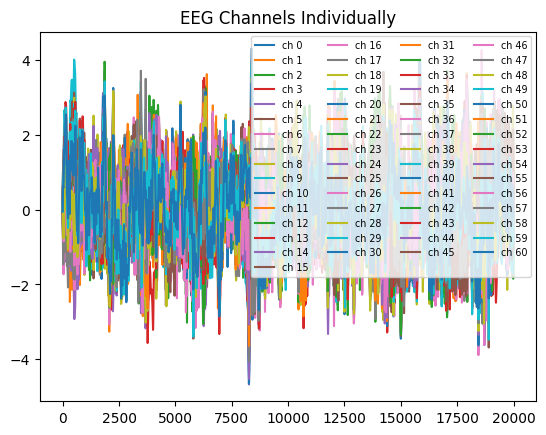

In [48]:
import matplotlib.pyplot as plt

trial = all_trials[0]['eeg']
for i, channel in enumerate(trial):
    plt.plot(channel, label=f'ch {i}')
plt.legend(loc='upper right', ncol=4, fontsize='x-small')
plt.title("EEG Channels Individually")
plt.show()


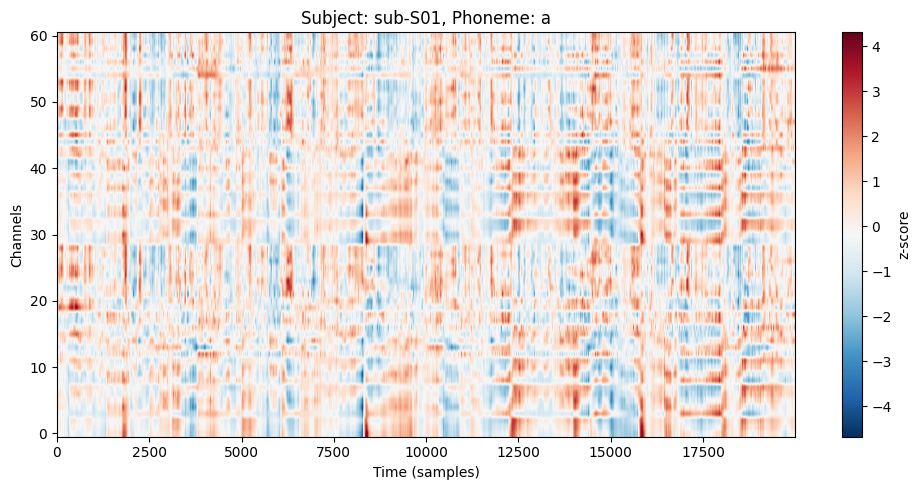

In [50]:
import matplotlib.pyplot as plt

example = all_trials[0]  

eeg_data = example['eeg']
phoneme = example['phoneme']
subject = example['subject']

plt.figure(figsize=(10, 5))
plt.imshow(eeg_data, aspect='auto', cmap='RdBu_r', origin='lower')
plt.colorbar(label='z-score')
plt.title(f"Subject: {subject}, Phoneme: {phoneme}")
plt.xlabel("Time (samples)")
plt.ylabel("Channels")
plt.tight_layout()
plt.show()


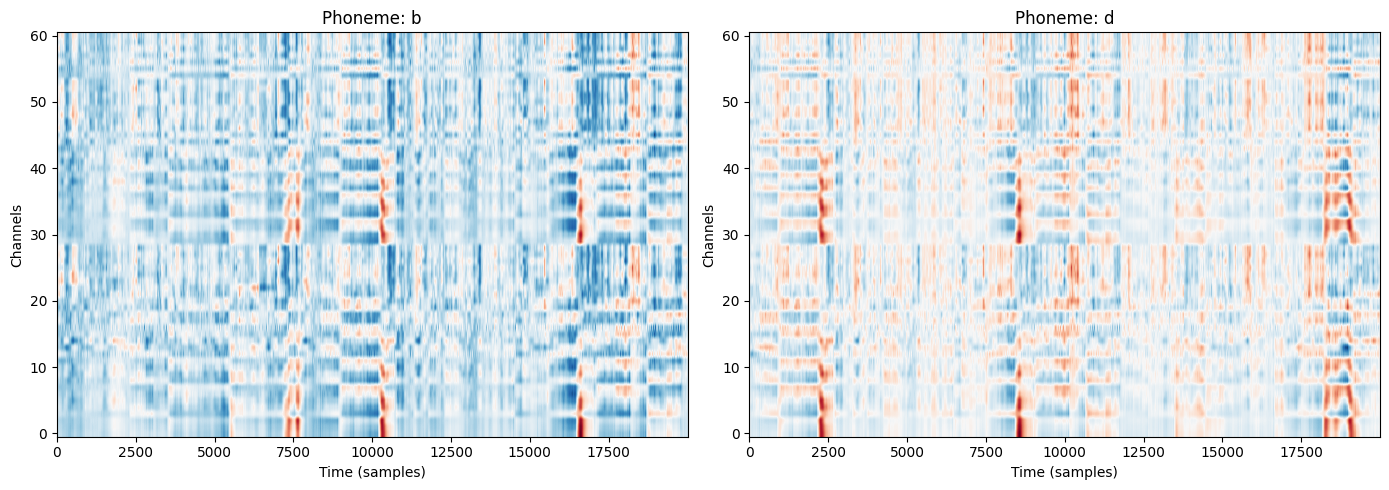

In [51]:

phoneme1 = 'b'
phoneme2 = 'd'

trial1 = next(t for t in all_trials if t['phoneme'] == phoneme1)
trial2 = next(t for t in all_trials if t['phoneme'] == phoneme2)


fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i, trial in enumerate([trial1, trial2]):
    axs[i].imshow(trial['eeg'], aspect='auto', cmap='RdBu_r', origin='lower')
    axs[i].set_title(f"Phoneme: {trial['phoneme']}")
    axs[i].set_xlabel("Time (samples)")
    axs[i].set_ylabel("Channels")

plt.tight_layout()
plt.show()


Load and preprocess EEG trials (filter, z-score, remove noisy channels)
Keep only trials with most common EEG shape
Split into training and test sets (80/20, stratified)
Visualize training data using PCA (3D)
Train SVM classifier on X_train, y_train
Evaluate model on X_test (accuracy, report, confusion matrix)

In [52]:
from collections import Counter

# Retrieve the EEG shape for each trial
shapes = [trial['eeg'].shape for trial in all_trials]
most_common_shape = Counter(shapes).most_common(1)[0][0]

# Filter only trials with the most common shape
filtered_trials = [trial for trial in all_trials if trial['eeg'].shape == most_common_shape]

print(f"✅ Using only trials with shape: {most_common_shape}")


✅ Using only trials with shape: (62, 20000)


In [53]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def extract_features_statistical(trial):
    eeg = trial['eeg']
    features = []
    features.extend(np.mean(eeg, axis=1))
    features.extend(np.std(eeg, axis=1))
    features.extend(np.max(eeg, axis=1))
    features.extend(np.min(eeg, axis=1))
    features.extend(np.sum(eeg ** 2, axis=1))
    return np.array(features)

# Apply feature extraction
X = np.array([extract_features_statistical(trial) for trial in filtered_trials])

# Encode phoneme labels
phoneme_labels = [trial['phoneme'] for trial in filtered_trials]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(phoneme_labels)

print("✅ X shape (statistical features):", X.shape)
print("✅ y shape:", y.shape)
print("✅ Classes:", label_encoder.classes_)


✅ X shape (statistical features): (416, 310)
✅ y shape: (416,)
✅ Classes: ['a' 'b' 'd' 'e' 'i' 'o' 'p' 's' 't' 'u' 'z']


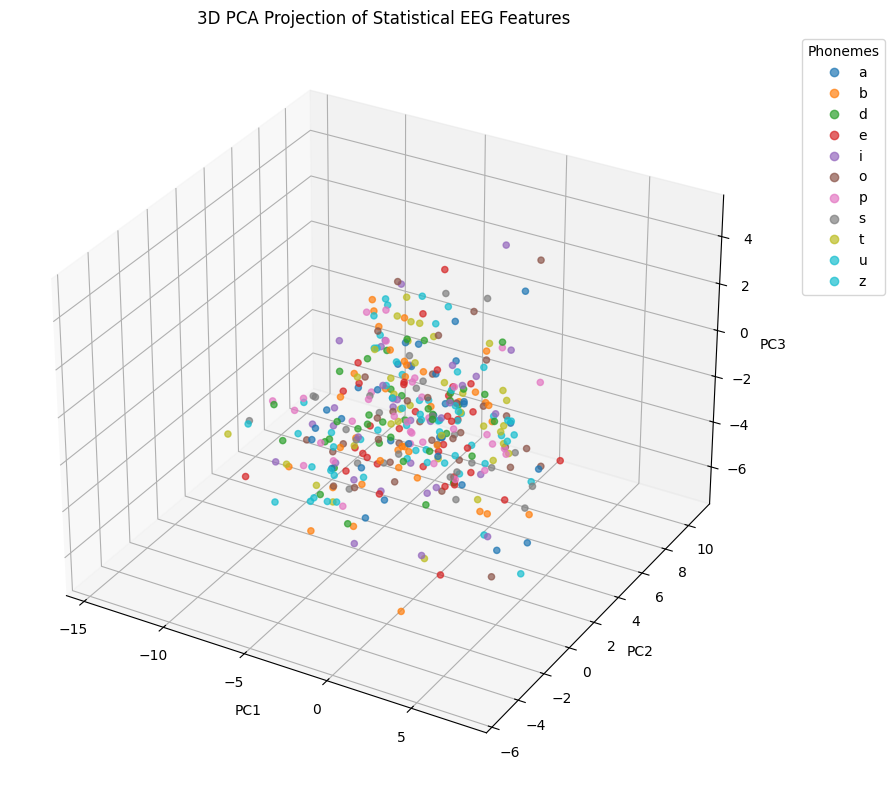

In [55]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# PCA to 3 components
pca_3d = PCA(n_components=3, random_state=42)
X_3d = pca_3d.fit_transform(X_train)

# Labels for coloring
labels = y_train

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)

# Convert label indices to class names (as list, not numpy array)
legend_labels = label_encoder.inverse_transform(np.unique(labels)).tolist()

# Add legend
ax.legend(handles=scatter.legend_elements()[0],
          labels=legend_labels,
          title="Phonemes",
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Projection of Statistical EEG Features')
plt.tight_layout()
plt.show()


In [56]:
import numpy as np

def extract_features_statistical(trial):
    eeg = trial['eeg']  # shape: [channels × time]
    features = []

    # Feature 1: mean per channel
    features.extend(np.mean(eeg, axis=1))

    # Feature 2: std per channel
    features.extend(np.std(eeg, axis=1))

    # Feature 3: max per channel
    features.extend(np.max(eeg, axis=1))

    # Feature 4: min per channel
    features.extend(np.min(eeg, axis=1))

    # Feature 5: energy per channel (sum of squares)
    features.extend(np.sum(eeg ** 2, axis=1))

    return np.array(features)

# === Apply feature extraction to all filtered trials ===
X = np.array([extract_features_statistical(trial) for trial in filtered_trials])
y = label_encoder.transform([trial['phoneme'] for trial in filtered_trials])

print("✅ X shape (statistical features):", X.shape)
print("✅ y shape:", y.shape)


✅ X shape (statistical features): (416, 310)
✅ y shape: (416,)


In [58]:

from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserve phoneme distribution
)

print("✅ X_train shape:", X_train.shape)
print("✅ X_test shape:", X_test.shape)


✅ X_train shape: (332, 310)
✅ X_test shape: (84, 310)


In [59]:
from sklearn.svm import SVC

# Train a linear Support Vector Machine (SVM)
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

print("✅ SVM model trained successfully")


✅ SVM model trained successfully


In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict phoneme labels for the test set
y_pred = clf.predict(X_test)

# Accuracy
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification metrics
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix (optional to visualize later)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.09523809523809523

=== Classification Report ===
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         8
           b       0.00      0.00      0.00         7
           d       0.00      0.00      0.00         7
           e       0.00      0.00      0.00         8
           i       0.00      0.00      0.00         8
           o       0.10      1.00      0.18         8
           p       0.00      0.00      0.00         8
           s       0.00      0.00      0.00         7
           t       0.00      0.00      0.00         7
           u       0.00      0.00      0.00         8
           z       0.00      0.00      0.00         8

    accuracy                           0.10        84
   macro avg       0.01      0.09      0.02        84
weighted avg       0.01      0.10      0.02        84


=== Confusion Matrix ===
[[0 0 0 0 0 8 0 0 0 0 0]
 [0 0 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.